# Modeling

In [13]:
# import libraries


import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [14]:
#creating matrices for sklearn:
train = pd.read_csv('../datasets/train_processed.csv')
test = pd.read_csv('../datasets/test_processed.csv')

In [15]:
features = [x for x in train.columns if x not in ['saleprice', 'id']]

In [16]:
X = train[features]
y = train.saleprice

### 1. OLS regression 

**With scaling**

In [17]:
# Create train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [18]:
# Using RobustScaler as the data could still contain some outliers
lr = make_pipeline(RobustScaler(), LinearRegression())

In [19]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.937415894944247, -2.2860661106416657e+22)

#### RMSE 

In [20]:
np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))

60246637083.04324

OLS model performs very poorly - the R2 score and RMSE is insanely high.

### 2. Ridge (L2 Penalty)

In [21]:
# Using pipeline and gridsearch to optimize the hyper parameters
ridge_pipe= make_pipeline(RobustScaler(), Ridge())

In [22]:
ridge_pipe.get_params()

{'memory': None,
 'steps': [('robustscaler',
   RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
          with_scaling=True)),
  ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001))],
 'robustscaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True),
 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'robustscaler__copy': True,
 'robustscaler__quantile_range': (25.0, 75.0),
 'robustscaler__with_centering': True,
 'robustscaler__with_scaling': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [23]:
ridge_params = {
    'ridge__alpha': np.logspace(0, 5, 200),
    'ridge__random_state': [42]
}

In [24]:
gs_ridge = GridSearchCV(estimator = ridge_pipe, 
                        param_grid = ridge_params,
                        verbose = 1,
                        n_jobs = -1,
                        cv = 5)

gs_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   26.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'ridge__alpha': array([1.00000e+00, 1.05956e+00, ..., 9.43788e+04, 1.00000e+05]), 'ridge__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [25]:
gs_ridge.score(X_train, y_train), gs_ridge.score(X_test, y_test)

(0.9386710044395351, 0.9226982317777791)

#### RMSE

In [26]:
np.sqrt(mean_squared_error(y_test, gs_ridge.predict(X_test)))

0.1107855533585088

With regularization and hyperparameters tuning, we are able to bring down the R2 score and RMSE!

Ridge picked 191 features and eliminated the other 6 features


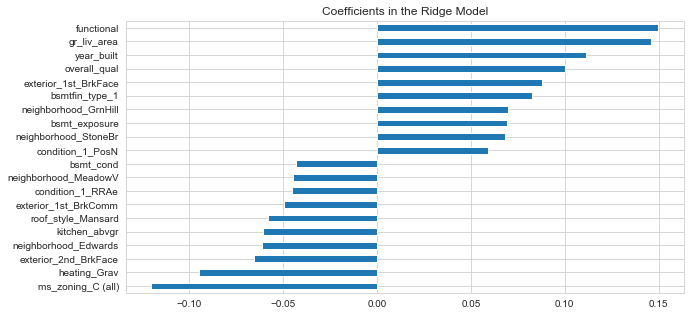

In [27]:
# Plot important coefficients
coefs = pd.Series(gs_ridge.best_estimator_.named_steps['ridge'].coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", figsize = (10,5))
plt.title("Coefficients in the Ridge Model")
plt.show()

By the Ridge model, these features are among the top 4 that increase the price the most, namely: how well the property is functional, the ground living area, how recent the property was built and overall quality.

The top minus point here seems the heating type being gravity furnace.

### 3.3. Lasso (L1 Penalty)

In [28]:
lasso_pipe = make_pipeline(RobustScaler(), Lasso())

In [29]:
lasso_pipe.get_params()

{'memory': None,
 'steps': [('robustscaler',
   RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
          with_scaling=True)),
  ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))],
 'robustscaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True),
 'lasso': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'robustscaler__copy': True,
 'robustscaler__quantile_range': (25.0, 75.0),
 'robustscaler__with_centering': True,
 'robustscaler__with_scaling': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 '

In [30]:
lasso_params = {
    'lasso__alpha': np.arange(0.001, 0.5, 0.005),
    'lasso__random_state': [42]
}

In [31]:
gs_lasso = GridSearchCV(estimator = lasso_pipe, 
                        param_grid = lasso_params,
                        verbose = 1,
                        n_jobs = -1,
                        cv = 5)

In [32]:
gs_lasso.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lasso__alpha': array([0.001, 0.006, ..., 0.491, 0.496]), 'lasso__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [33]:
gs_lasso.score(X_train, y_train), gs_lasso.score(X_test, y_test)

(0.9266958924511968, 0.9184096477893581)

In [34]:
np.sqrt(mean_squared_error(y_test, gs_lasso.predict(X_test)))

0.11381718001387858

Lasso picked 57 features and eliminated the other 140 features


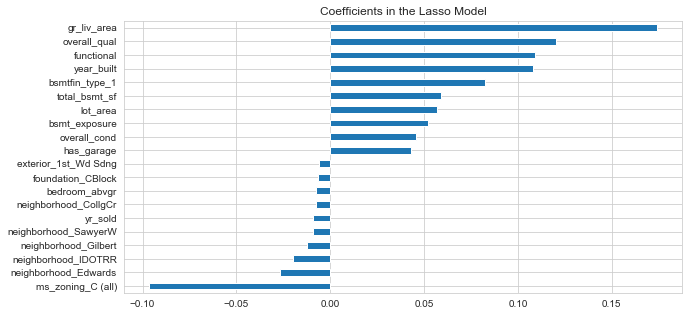

In [35]:
# Plot important coefficients
coefs = pd.Series(gs_lasso.best_estimator_.named_steps['lasso'].coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", figsize = (10,5))
plt.title("Coefficients in the Lasso Model")
plt.show()

In the Lasso model, the top plus points for housing price are inline with the previous Ridge model.

However the deduction point now turns to neighborhood being 'Edwards' but only with a very weak correlation. This probably doesn't make sense at all - if possible, we should engage domain expert to improve feature engineering on the neiborhood feature.

### 3.4. Elastic Net (L1 + L2 Penalty)

In [36]:
el_pipe = make_pipeline(RobustScaler(), ElasticNet())

In [37]:
el_pipe.get_params()

{'memory': None,
 'steps': [('robustscaler',
   RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
          with_scaling=True)),
  ('elasticnet',
   ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
         max_iter=1000, normalize=False, positive=False, precompute=False,
         random_state=None, selection='cyclic', tol=0.0001, warm_start=False))],
 'robustscaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True),
 'elasticnet': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'robustscaler__copy': True,
 'robustscaler__quantile_range': (25.0, 75.0),
 'robustscaler__with_centering': True,
 'robustscaler__with_scaling': True,
 'elasticnet__alpha': 1.0,
 'elasticnet__copy_X': True,
 'elasticnet__fit_intercept': True,
 'ela

In [38]:
el_params = {'elasticnet__alpha': np.arange(0.01, 1.0, 0.05),
             'elasticnet__l1_ratio': np.arange(0.01, 1.0, 0.05),
             'elasticnet__random_state': [42]}

In [39]:
gs_el = GridSearchCV(estimator = el_pipe, 
                        param_grid = el_params,
                        verbose = 1,
                        n_jobs = -1,
                        cv = 5)

In [40]:
gs_el.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   50.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'elasticnet__alpha': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]), 'elasticnet__l1_ratio': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]), 'elasticnet__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [41]:
gs_el.score(X_train, y_train), gs_el.score(X_test, y_test)

(0.9338229575115888, 0.9209399909434317)

#### RMSE

In [42]:
np.sqrt(mean_squared_error(y_test, gs_el.predict(X_test)))

0.11203838682756047

Elastic Net picked 140 features and eliminated the other 57 features


Text(0.5, 1.0, 'Coefficients in the ElasticNet Model')

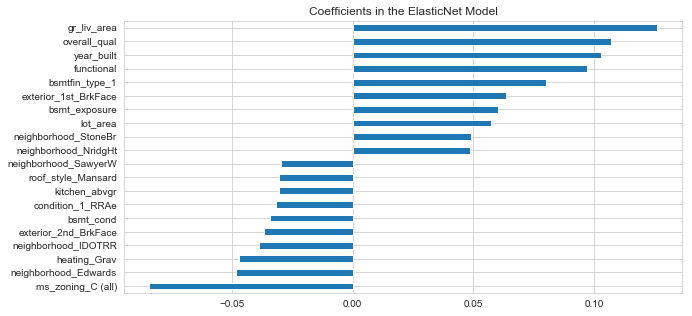

In [43]:
# Plot important coefficients
coefs = pd.Series(gs_el.best_estimator_.named_steps['elasticnet'].coef_, index = X_train.columns)
print("Elastic Net picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", figsize = (10,5))
plt.title("Coefficients in the ElasticNet Model")
##plt.show()

Same observation as the Lasso model

## Summary

|Model|R2 (train)|R2 (test)|RMSE (USD)|
|:--- | --- | --- | --- | 
|OLS (no regularization)|0.944| -4.17e+20|8.48X10^9|
|Ridge (L2 penalty)|0.941|0.913|0.120|
|Lasso (L1 penalty)|0.929|0.906|0.122
|Elastic Net|0.935|0.911|0.124

In general, with regularization and hyperparameter tuning, we are able to achieve an RMSE of about ~0.12 USD for our model. All the three models (Ridge, Lasso and Elastic Net) are consistent in identifying the top correlated features, namely: how well the property can function, the ground living area, how recent the property was built and the overall material and finish quality.


After reviewing all the models evaluated so far, I will proceed with the Ridge and Elastic Net models for submission of the kaggle challenge.

**Caveat:**
- Although the RMSE may look reasonably good, the model has its own limitation. It might not be able to produce a good fit for housing properties of rare type such as those with pools or those in agricultural zones. Recall that we have removed a few features due to limited samples in certain categories, e.g. pool_area was removed as only less than 4% of the properties have pools.
- The model still has room for further improvement if domain expert could step in during the feature selection/engineering stage. For example, there are 28 categories in the 'neighorhood' feature. It could certainly be refined if we know that if there are ways to group the neighborhood to reduce complexity of the model. 

In [44]:
# Generate file for submission for lasso model

In [45]:
predictions = np.expm1(gs_ridge.predict(test[features]))

In [46]:
test_ridge = test.copy()

In [47]:
test_ridge['saleprice'] = predictions

In [48]:
test_ridge = test_ridge[['id','saleprice']]

In [49]:
test_ridge.columns = ['Id','SalePrice']

In [50]:
test_ridge.to_csv('../submission/ridge.csv', index=False)

In [51]:
# Generate file for submission for elastic net model

In [52]:
predictions = np.expm1(gs_el.predict(test[features]))

In [53]:
test_el = test.copy()

In [54]:
test_el['saleprice'] = predictions

In [55]:
test_el = test_el[['id','saleprice']]

In [56]:
test_el.columns = ['Id','SalePrice']

In [57]:
test_el.to_csv('../submission/elasticnet.csv', index=False)

## Reference

How the dataset was put together [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf) by Dean De Cock

Thorough features engeneering from Kaggle [A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) by Julien Cohen-Solal